I copied alot from these blogs:

https://github.com/devnag/pytorch-generative-adversarial-networks

http://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/

# Imports

In [1]:
%matplotlib inline  
import sys
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
sys.argv.append('--dynet-autobatch')
sys.argv.append('1')
import dynet as dy
dy.init()

# Create Data

In [2]:
sample_size = 100
disc_num_hidden = 1
gen_num_hidden = 2
hidden_size = 50
disc2gen_ratio = 5
mu = 4
sigma = 1.25
noise_size = 4

#optimizer = lambda model:  dy.RMSPropTrainer(model, 5e-5)
optimizer = lambda model:  dy.RMSPropTrainer(model)

def sample_target():
    return np.random.normal(mu, sigma, sample_size)
    
def sample_noise():
    return np.random.rand(noise_size)

def print_dist(sample1, sample2):
    display.clear_output(wait=True)
    plt.hist(sample1, 50, normed=True, color="red")
    plt.hist(sample2, 50, normed=True, color="blue")
    #plt.axis([-2, 2, 0, 10])
    plt.show()

# Utils

In [3]:
def np2dy(x):
    dy_vec = dy.vecInput(len(x))
    dy_vec.set(x)
    return dy_vec

class Perceptron:
    def __init__(self, in_size, out_size, model):
        self.model = model
        self.w = self.model.add_parameters((out_size, in_size))
        self.b = self.model.add_parameters((out_size))
        
    def __call__(self, x):
        w = dy.parameter(self.w)
        b = dy.parameter(self.b)
        return w*x+b

# Models

In [4]:
class Generator:
    def __init__(self):
        self.model = dy.Model() 
        
        self.h1 = Perceptron(noise_size, hidden_size, self.model)
        self.hiddens = [Perceptron(hidden_size, hidden_size, self.model)  for _ in range(gen_num_hidden)]
        self.h2 = Perceptron(hidden_size, 1, self.model)
        
        self.opt = optimizer(self.model)
       
    def __call__(self):
        output = []
        for _ in range(sample_size):
            x = sample_noise()
            x = np2dy(x)
            h = dy.rectify(self.h1(x))
            for layer in self.hiddens:
                h = dy.rectify(layer(h))
            #return self.h2(h)
            output.append(self.h2(h))
        return dy.concatenate(output)

class Discriminator:
    def __init__(self):
        self.model = dy.Model() 
        
        self.h1 = Perceptron(1, hidden_size, self.model) 
        self.hiddens = [Perceptron(hidden_size, hidden_size, self.model)  for _ in range(disc_num_hidden)]
        self.h2 = Perceptron(hidden_size, 1, self.model) 
        
        self.opt = optimizer(self.model)
        
    def __call__(self, x):
        outs = []
        for i in range(sample_size):
            h = x[i]
            h = dy.rectify(self.h1(h))
            for layer in self.hiddens:
                h = dy.rectify(layer(h))
            outs.append(self.h2(h))
        return dy.average(outs)

d = Discriminator()
g = Generator()

# Train

In [5]:
mean = []
var = []
def test():
    generated = g().npvalue()
    print_dist(sample_target(), generated)
    mean.append(np.mean(generated))
    var.append(np.var(generated))
    print("Mean: "+str(mean[-1])+" Var: "+str(var[-1]))

def optimize(loss, opt):
    loss.value()
    loss.backward()
    opt.update()
    

def train_disc(d, g, epochs):
    for _ in range(epochs):
        dy.renew_cg()
        
        target = np2dy(sample_target())
        real_loss = d(target)
        
        generated = np2dy(g().npvalue())
        fake_loss = d(generated)
        optimize(fake_loss-real_loss, d.opt)
    
def train_gen(d, g, epochs):
    for _ in range(epochs):
        dy.renew_cg()
        generated = g()
        loss = d(generated)
        optimize(-loss, g.opt)
        
def train(d, g, epochs, inner_epochs):
    for i in tqdm(range(epochs)):
        train_disc(d, g, inner_epochs*disc2gen_ratio)
        train_gen(d, g, inner_epochs)
        if i % 200 == 0:
            test()

# Else

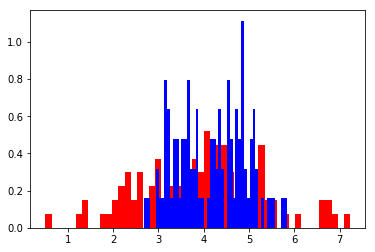

 96%|█████████▌| 4805/5000 [02:40<00:09, 21.01it/s]

Mean: 4.18054105997 Var: 0.567485165532


100%|██████████| 5000/5000 [02:46<00:00, 30.00it/s]


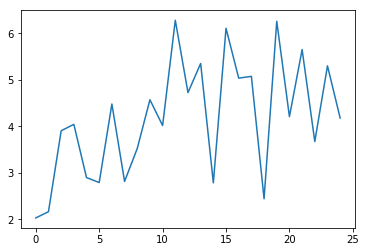

<function matplotlib.pyplot.show>

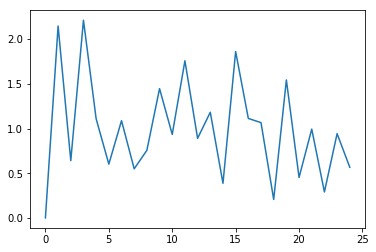

In [6]:
train(d, g, 5000, 1)

plt.plot(mean)
plt.show()
plt.plot(var)
plt.show

TODO: add weight clipping